In [62]:
from mpmath import mp, fp
mp.dps = 5
fp.dps = 5

In [1]:
import pandas as pd

In [2]:
import seaborn as sns 
sns.set(style="darkgrid")

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


# Introduction

In this notebook we compare different numerical approaches to computing the posterior expectations, $E[Z^n \mid y, \sigma, \tau]$ for $n=1, 0$.  These values are then used in the following SURE calculation. 

In [4]:
def SURE_hs_single(y, E_Z_hs_func, sig=1., tau=1., **kwargs):
    r""" Compute SURE for a given :math:`E[Z^k]` implementation.
    
    Parameters
    ==========
    y: float
        Observation
    E_Z_hs_func: function
        A function that takes the same inputs as this one and
        returns a pair corresponding to value and computation
        type.
    sig: float
        Error std. dev
    tau: float
        Global shrinkage parameter
        
    Returns
    =======
    tuple (float, str)
        A SURE value and computation type for the given point.
    """
    E_1 = E_Z_hs_func(y, sig=sig, tau=tau, n=1, **kwargs)
    E_2 = E_Z_hs_func(y, sig=sig, tau=tau, n=2, **kwargs)
    res = 2. * sig**2 - (y * sig**2 * E_1[0])**2
    res += 2. * (-sig**2 * E_1[0] + y**2 * E_2[0])
    return (res, '{}-{}'.format(E_1[1], E_2[1]))

SURE_hs = np.vectorize(SURE_hs_single, excluded=set([1]), 
                       otypes=[float, str])

Since each implementation makes separate computations of $E[Z^n]$ and $E[Z]$ for large $y$, they are all expected to fail when $E[Z^n]$ and $E[Z]$ correspondingly become too large for floating point precision.  Although the two quantities are ultimately divided, we should still get overflow errors, so, when we do, we catch the errors and perform the infinite precision calculation.  If the infinite precision calculation fails, which it can given maximum iteration limits, we return `NaN`.  In all cases, we label the values by their method of computation.

## Finite Precision $\Phi_1$

This method estimates $E[Z]$ using `mpmath.hyper2d`, which is designed to directly estimate $\Phi_1$.

In [5]:
def E_Z_hs_num_single(y, sig=1., tau=1., n=1):
    try:
        # (double) floating point calculations
        res = fp.rf(1., n)/fp.rf(3/2., n)
        res *= fp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          1. - 1./tau**2, (y/sig)**2/2.)
        res /= fp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          1. - 1./tau**2, (y/sig)**2/2.)
        return (res, 'fp')
    except:
        pass
    try:
        # If it fails, use the direct infinite precision calculations.
        res = mp.rf(1., n)/mp.rf(3/2., n)
        res *= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          1. - 1./tau**2, (y/sig)**2/2.)
        res /= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          1. - 1./tau**2, (y/sig)**2/2.)
        return (res, 'inf')
    except:
        pass
    return (np.nan, 'failed')

In [6]:
y_range = pd.Series(np.linspace(-50, 50, 500), name='y')

In [7]:
%%time
SURE_num_vals = SURE_hs(y_range, E_Z_hs_num_single, tau=1)

CPU times: user 697 ms, sys: 36 ms, total: 733 ms
Wall time: 687 ms


In [8]:
from timeit import timeit
timeit(stmt=lambda: SURE_hs(y_range, E_Z_hs_num_single, tau=1),
       number=10)

6.547171115875244

In [9]:
SURE_num_df = pd.DataFrame(zip(*SURE_num_vals), index=y_range, 
                           columns=['SURE', 'precision'])

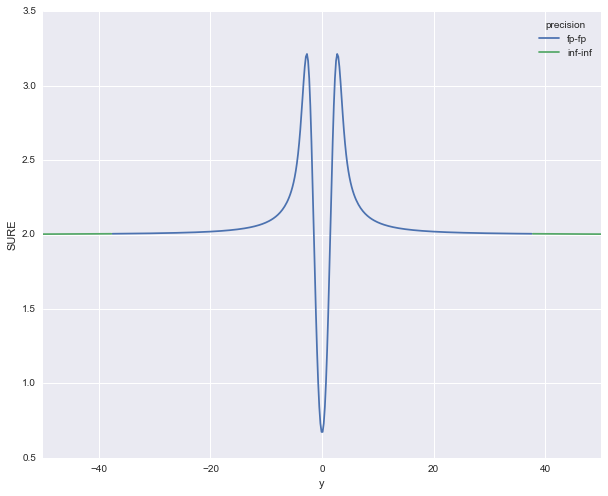

In [10]:
ax = SURE_num_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

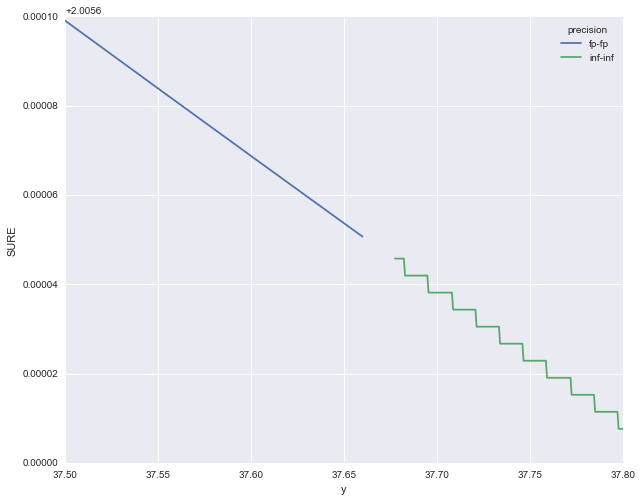

In [55]:
y_range_tail = pd.Series(np.linspace(37.5, 37.8, 500), name='y')
SURE_num_tail_vals = SURE_hs(y_range_tail, 
                             E_Z_hs_num_single, tau=1)
SURE_num_tail_df = pd.DataFrame(zip(*SURE_num_tail_vals), 
                                index=y_range_tail, 
                                columns=['SURE', 'precision'])
ax = SURE_num_tail_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

## $F_1(1/\epsilon)$ Hack

Below is a computation of $E[Z]$ using finite (double) precision floating point operations and a hack that uses the relationship between the Appell $F_1$ function and the Humbert/Horn $\Phi_1$ in which $E[Z]$ is defined here.  

In [12]:
def E_Z_hs_eps_single(y, sig=1., tau=1., n=1, eps=1e-5):
    try:
        # (double) floating point calculations
        res = fp.rf(1., n)/fp.rf(3/2., n)
        res *= fp.appellf1(0.5, 1./eps, 1., 3/2. + n,
                           eps * (y/sig)**2/2., 1. - 1./tau**2)
        res /= fp.appellf1(0.5, 1./eps, 1., 3/2.,
                           eps * (y/sig)**2/2., 1. - 1./tau**2)
        return (res, 'fp')
    except:
        pass
    try:
        # If it fails, use the direct infinite precision calculations.
        res = mp.rf(1., n)/mp.rf(3/2., n)
        res *= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          1. - 1./tau**2, (y/sig)**2/2.)
        res /= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          1. - 1./tau**2, (y/sig)**2/2.)
        return (res, 'inf')
    except:
        pass
    return (np.nan, 'failed')

In [13]:
%%time
SURE_eps_vals = SURE_hs(y_range, E_Z_hs_eps_single, tau=1, eps=1e-15)

CPU times: user 2.77 s, sys: 24 ms, total: 2.8 s
Wall time: 2.77 s


In [14]:
SURE_eps_df = pd.DataFrame(zip(*SURE_eps_vals), index=y_range, 
                           columns=['SURE', 'precision'])

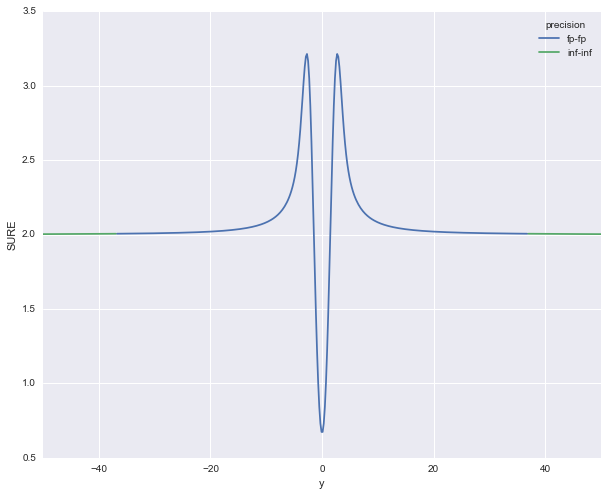

In [15]:
ax = SURE_eps_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

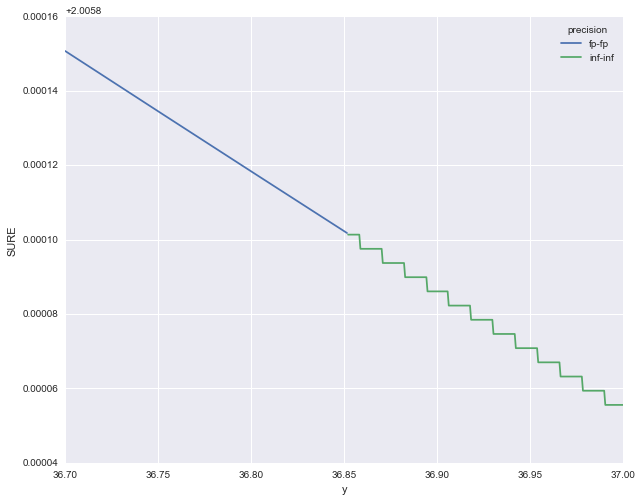

In [54]:
y_range_tail = pd.Series(np.linspace(36.7, 37, 500), name='y')
SURE_eps_tail_vals = SURE_hs(y_range_tail, 
                             E_Z_hs_eps_single, tau=1, eps=1e-15)
SURE_eps_tail_df = pd.DataFrame(zip(*SURE_eps_tail_vals), 
                                index=y_range_tail, 
                                columns=['SURE', 'precision'])
ax = SURE_eps_tail_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

## Truncation

Next, we try truncating the values of $y$ in the regions where $E[Z]$ fails for floating point calculations. 

In [17]:
def E_Z_hs_trunc_single(y, sig=1., tau=1., n=1, trunc_val=40.):
    if abs(y/sig) >= trunc_val:
        return (0., 'trunc')
    try:
        res = fp.rf(1., n)/fp.rf(3/2., n)
        res *= fp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          1. - 1./tau**2,
                          (y/sig)**2/2., maxterms=1e5)
        res /= fp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          1. - 1./tau**2,
                          (y/sig)**2/2., maxterms=1e5)
        return (res, 'fp')
    except:
        pass
    try:
        # If it fails, use the infinite precision calculations.
        res = mp.rf(1., n)/mp.rf(3/2., n)
        res *= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          1. - 1./tau**2, (y/sig)**2/2.)
        res /= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          1. - 1./tau**2, (y/sig)**2/2.)
        return (res, 'inf')
    except:
        pass
    return (np.nan, 'failed')

In [18]:
%%time
SURE_trunc_vals = SURE_hs(y_range, E_Z_hs_trunc_single, tau=1)

CPU times: user 385 ms, sys: 7 ms, total: 392 ms
Wall time: 377 ms


In [19]:
SURE_trunc_df = pd.DataFrame(zip(*SURE_trunc_vals), 
                             index=y_range, 
                             columns=['SURE', 'precision'])

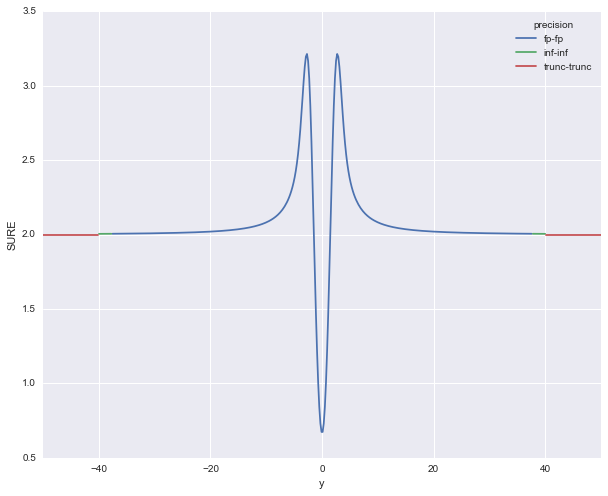

In [20]:
ax = SURE_trunc_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

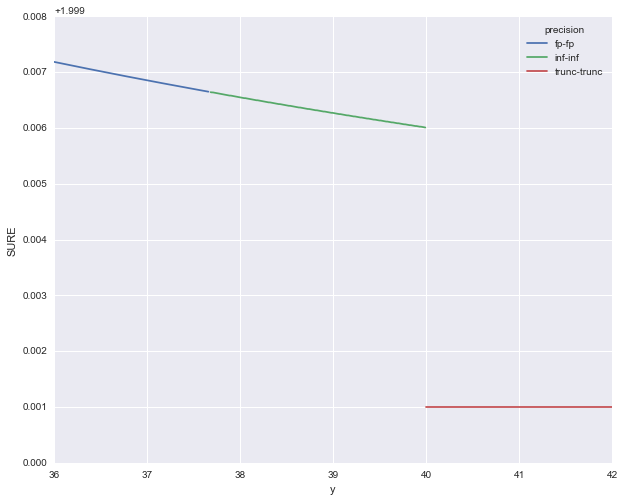

In [34]:
y_range_tail = pd.Series(np.linspace(36, 42, 500), name='y')
SURE_trunc_tail_vals = SURE_hs(y_range_tail, 
                               E_Z_hs_trunc_single, tau=1)
SURE_trunc_tail_df = pd.DataFrame(zip(*SURE_trunc_tail_vals), 
                                  index=y_range_tail, 
                                  columns=['SURE', 'precision'])
ax = SURE_trunc_tail_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

## Quadrature

This case simply uses finite precision numeric quadrature to estimate $E[Z]$.

In [45]:
from functools import partial

def E_Z_hs_quad_single(y, sig=1., tau=1., n=1):
    x_ = 1. - 1./tau**2
    y_ = (y/sig)**2/2.
    
    def phi_1_integrand_num(t, n_=0):
        res = t**(-0.5) * (1.-t)**(3/2.+n_-1.5)
        res *= fp.exp(y_ * t) / (1.-x_*t) 
        return res

    try:
        res = fp.rf(1., n)/fp.rf(3/2., n)
        res *= fp.gamma(3/2.+n)/fp.gamma(1+n)/fp.gamma(3/2.)
        res *= fp.quad(partial(phi_1_integrand_num, n_=n), 
                       [0, 1])
        res /= fp.quad(partial(phi_1_integrand_num, n_=0), 
                       [0, 1])
        return (res, 'fp')
    except:
        pass
    try:
        # If it fails, use the infinite precision calculations.
        res = mp.rf(1., n)/mp.rf(3/2., n)
        res *= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.+n},
                          x_, y_)
        res /= mp.hyper2d({'m+n': 0.5, 'm': 1.}, {'m+n': 3/2.},
                          x_, y_)
        return (res, 'inf')
    except:
        pass
    return (np.nan, 'failed')

In [46]:
%%time
SURE_quad_vals = SURE_hs(y_range, E_Z_hs_quad_single, tau=1)

CPU times: user 1.85 s, sys: 7 ms, total: 1.85 s
Wall time: 1.84 s


In [56]:
from timeit import timeit
timeit(stmt=lambda: SURE_hs(y_range, E_Z_hs_quad_single, tau=1),
       number=5)

8.96604609489441

In [47]:
SURE_quad_df = pd.DataFrame(zip(*SURE_quad_vals), 
                            index=y_range, 
                            columns=['SURE', 'precision'])

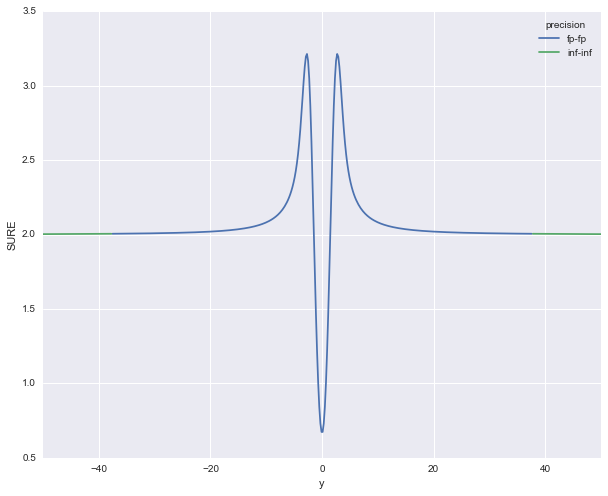

In [48]:
ax = SURE_quad_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

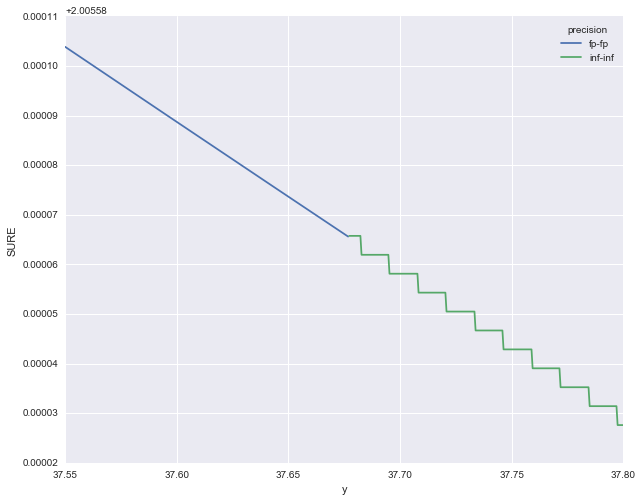

In [60]:
y_range_tail = pd.Series(np.linspace(37.55, 37.8, 500), name='y')
SURE_quad_tail_vals = SURE_hs(y_range_tail, 
                               E_Z_hs_quad_single, tau=1)
SURE_quad_tail_df = pd.DataFrame(zip(*SURE_quad_tail_vals), 
                                  index=y_range_tail, 
                                  columns=['SURE', 'precision'])
ax = SURE_quad_tail_df.pivot(columns='precision', values='SURE').plot()
_ = ax.set_ylabel("SURE")

# Conclusions and $\tau$ ranges

The direct $\Phi_1$ computation and numeric quadrature appear to do best in terms of accuracy and speed.  

All of the above was computed for only $\tau=1$, and upon changing this value, some other distinctions between methods begin to appear.  In general, the results aren't good for different values of $\tau$; however, it's possible that the Gordy forms of $\Phi_1$ would work better.

We briefly illustrate the effect of varying $\tau$ below.

In [63]:
y_range_tau = pd.Series(np.linspace(-50, 50, 50), name='y')

In [64]:
from timeit import default_timer as timer
E_Z_funcs = [E_Z_hs_num_single, E_Z_hs_trunc_single, E_Z_hs_quad_single]
SURE_tau_vals = []

# tau < 0.71 is unbearably long and then fails!  WTF!
for tau in [0.71, 0.8, 1.5, 2.5, 5.]:
    for E_Z_func in E_Z_funcs:
        start = timer()
        SURE_tau_val = SURE_hs(y_range_tau, E_Z_func, tau=tau)
        end = timer()
        print("tau={}, {}: {} secs".format(tau, 
                                           E_Z_func.__name__, 
                                           end-start))
        SURE_tau_val = pd.DataFrame(np.asarray(SURE_tau_val).T, 
                                    index=y_range_tau,
                                    columns=['SURE', 'precision'])
        SURE_tau_val['type'] = E_Z_func.__name__.split('_')[-2]
        SURE_tau_val['tau'] = tau
        SURE_tau_vals += [SURE_tau_val]

tau=0.71, E_Z_hs_num_single: 21.9975869656 secs
tau=0.71, E_Z_hs_trunc_single: 26.5072388649 secs
tau=0.71, E_Z_hs_quad_single: 6.83068990707 secs
tau=0.8, E_Z_hs_num_single: 20.6433160305 secs
tau=0.8, E_Z_hs_trunc_single: 16.3297638893 secs
tau=0.8, E_Z_hs_quad_single: 7.2850060463 secs
tau=1.5, E_Z_hs_num_single: 21.7059290409 secs
tau=1.5, E_Z_hs_trunc_single: 16.9456689358 secs
tau=1.5, E_Z_hs_quad_single: 6.82405281067 secs
tau=2.5, E_Z_hs_num_single: 21.0273001194 secs
tau=2.5, E_Z_hs_trunc_single: 16.8646509647 secs
tau=2.5, E_Z_hs_quad_single: 7.07303714752 secs
tau=5.0, E_Z_hs_num_single: 22.6930098534 secs
tau=5.0, E_Z_hs_trunc_single: 20.5155849457 secs
tau=5.0, E_Z_hs_quad_single: 6.81652402878 secs


In [65]:
SURE_tau_vals = pd.concat(SURE_tau_vals)
SURE_tau_vals['precision'] = SURE_tau_vals['precision'].astype("category")
SURE_tau_vals['type'] = SURE_tau_vals['type'].astype("category")
SURE_tau_vals['tau'] = SURE_tau_vals['tau'].astype("category")
SURE_tau_vals['SURE'] = SURE_tau_vals['SURE'].astype(np.float)

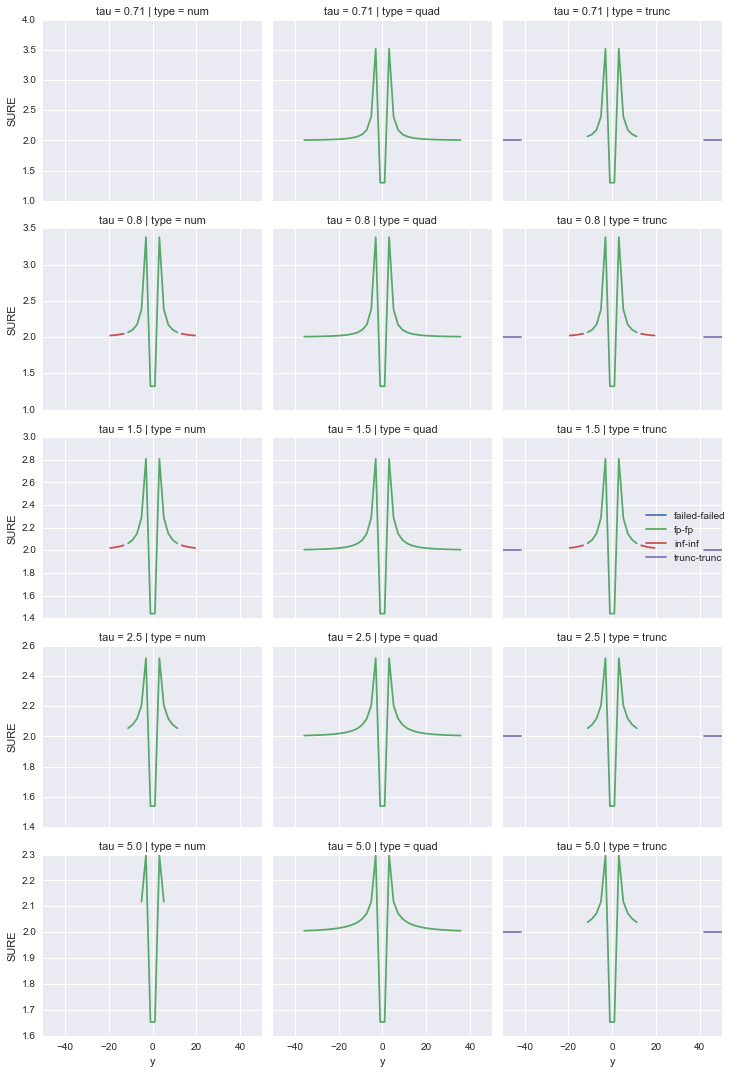

In [69]:
def pdplot(*args, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    pdata = data.pivot_table(index=data.index, 
                             columns='precision', 
                             values='SURE')
    if not pdata.empty:
        dplt = pdata.plot(ax=ax)

#%pdb
g = sns.FacetGrid(SURE_tau_vals, col="type", row="tau", 
                  sharey='row')
gp = g.map_dataframe(pdplot, 'y', 'SURE')
plt.subplots_adjust(top=0.9)
gp.add_legend()
gp.fig.tight_layout()

Numeric quadrature is the clear winner here; it roughly maintains the same computation time and $y$ range across all these $\tau$ values.  Still, it takes too long and fails at the basic finite precision range (which appears to be $|y| \approx 36$).  Plus, we have to consider actual accuracy, which can't really be assessed with this experiment.